### Estimation of risk premia

Functions in order:
   * func `FM`
   * func `PCAFM`
   * func `main_simulation`

# Part 0: Set up

In [1]:
# load necessary packages

import pandas as pd
import numpy as np
from scipy.io import loadmat, savemat
import scipy.stats as stats
from scipy.linalg import fractional_matrix_power as mpower


from numpy import diag, sqrt, sort, argsort, log, isnan, var, std, nanmean, kron
from numpy.random import randn, choice, random
from numpy.linalg import norm, inv, lstsq, svd, eig
from numpy.matlib import repmat


import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Part 1: Introduction
One of the central predictions of asset pricing models is that some risk factors { for example, intermediary capital or aggregate liquidity { should command a risk premium: investors should be compensated for their exposure to those factors, holding constant their exposure to all other sources of risk.

Sometimes, this prediction is easy to test in the data: when the factor predicted by theory is itself a portfolio (what we refer to as a tradable factor), the risk premium can be directly computed as the average excess return of the factor. This is for example the case for the CAPM, where the theory predicted factor is the market portfolio. 

Most theoretical models, however, predict that investors are concerned about nontradable risks: risks that are not themselves portfolios, like consumption, iflation, liquidity, and so on. Estimating the risk premium of a nontradable factor requires the construction of a tradable portfolio that isolates that risk, holding all other risks constant. While different estimators have been proposed for risk premia(most prominently, two-pass cross-sectional regressions like Fama-MacBeth regressions and mimicking portfolio projections), they are all affected by one common potential issue: omitted variable bias.

Omitted variable bias arises in standard risk premia estimators whenever the model used in the estimation does not fully account for all priced sources of risk in the economy. This is a fundamental concern when testing asset pricing theories, because theoretical models are usually very stylized and cannot possibly explicitly account for all the risks that are at play in the economy. While the possibility of omitted variable bias is known in the literature (see, for example, Jagannathan and Wang (1998)), no systematic solution has been proposed so far; rather, this problem is typically addressed in adhoc ways that differ from case to case. Studies using the two-pass cross-sectional regression approach typically add somewhat arbitrarily chosen factors or characteristics as controls, like the Fama-French three factors; studies using the mimicking-portfolio approach usually select a small set of portfolios (for example, portfolios sorted by size and book-to-market) on which to project the factor of interest. There is, however, no theoretical guarantee that the controls or the spanning portfolios are adequate to correct the omitted variable bias.

We propose a general solution to the omitted variable problem in linear asset pricing models. We introduce a new three-pass methodology that exploits (i) the large dimensionality of available test assets, and (ii) a rotation invariance result, to correctly recover the risk premium of any observable factor, even when not all true risk factors are observed and included in the model.

The starting point of our procedure is a simple but general rotation invariance result that holds for risk premia in linear factor models. Suppose that returns follow a linear factor model with p factors, and we wish to determine the risk premium of one of them, $g_{t}$. What we describe as a rotation-invariance result is the observation that the risk premium of $g_{t}$ is invariant to how the $p-1$ "control" factors are
"rotated" ----any $p-1$ linear combinations of the original $p$ factors can serve as control factors, as long as the rotated factor model spans the same risks as the original model.

This result implies that knowing the identities of all true factors is not necessary to estimate the risk premium of one of them ($g_{t}$). As long as the entire factor space can be recovered, the risk premium of $g_{t}$ can be identified even when the other factors are neither observed nor known. A natural way to recover the factor space in this scenario is to extract principal components (PCs) of the test asset returns. Our methodology, therefore, combines the principal component analysis (PCA) with two-pass cross-sectional regressions to provide consistent estimates of the risk premium for any observed factor.

Our methodology proceeds in three steps. First, we use PCA to extract factors and their loadings from a large panel of test asset returns, thus recovering the factor space (i.e., some unknown rotation of the $p$ factors). Second, we run a cross-sectional regression using only the PCs (without the factor of interest gt) to find their risk premia. Third, we estimate a time-series regression of $g_{t}$ onto the PCs, that uncovers the relation between $g_{t}$ and the latent factors, and in addition removes potential measurement error from $g_{t}$. The risk premium of $g_{t}$ is then estimated as the product of the loadings of $g_{t}$ on the PCs (estimated in the third step) and their risk premia (estimated in the second step). The invariance result discussed above is what guarantees the identification of the risk premium of $g_{t}$, regardless of the rotation of the true factors that occur when extracting PCs.

Our three-pass procedure can be interpreted in light of the two standard methods for risk premium estimation. First, it can be viewed as a PC-augmented two-pass cross-sectional regression. Rather than selecting the control factors for $g_{t}$ arbitrarily, the PCs of the test asset returns are used as controls; these stand in for the omitted factors and, thanks to the rotation invariance result, fully correct the omitted variable bias. Second, our procedure can be interpreted as a regularized version of the mimicking portfolio approach. The factor $g_{t}$ is projected onto the PCs of returns (the PCs are themselves portfolios) rather than onto an arbitrarily chosen set of portfolios, which could lead to a bias, or onto the entire set of test assets, which would be inefficient or even infeasible when the number of test assets is larger than the sample size.

### Preparations
Throughout the assignment, we use $(A : B)$ to denote the concatenation (by columns) of two matrices $A$ and $B$. $e_{i}$ is a vector with 1 in the $i$th entry and 0 elsewhere, whose dimension depends on the context. $\iota_{k}$ denotes a $k$-dimensional vector with all entries being 1, and $\mathbb{I}_{d}$ denotes the $d \times d$ identity matrix. For any time series of vectors $\lbrace a_{t}\rbrace_{t=1}^{T}$, we denote $\bar{a} = \frac{1}{T} \sum_{t=1}^{T} a_{t} $. In addition, we write $\bar{a}_{t} = a_{t} − \bar{a}$. We use the capital letter $A$ to denote the matrix $(a_{1} : a_{2} : ... : a_{T} )$, and write $\bar{A} = A − \bar{a} \iota_{T}^{\intercal}$ correspondingly. We denote $\mathbb{P}_{A} = A(A^{\intercal}A)^{-1}A^{\intercal}$ and $\mathbb{M}_{A} = \mathbb{I}_{d}− \mathbb{P}_{A}$, for some $d \times T$ matrix $A$. We use $a \lor b$ to denote the
max of $a$ and $b$, and $a \land b$ as their min for any scalars $a$ and $b$.

First, load the calibrated parameters and note the shape of each of the parameters. Keep these in mind as we move on.

In [2]:
param = pd.read_pickle('Calibrated_Parameters.pkl')
Sigmabeta  = param['Sigmabeta']
print(Sigmabeta.shape)
beta0      = param['beta0']
print(beta0.shape)
Sigmau     = param['Sigmau']
print(Sigmau.shape)
eta        = param['eta']
print(eta.shape)
gamma      = param['gamma']
print(gamma.shape)
sigmaalpha = param['sigmaalpha']
print(sigmaalpha.shape)
Sigmaw     = param['Sigmaw']
print(Sigmaw.shape)
Sigmav     = param['Sigmav']
print(Sigmav.shape)

(5, 5)
(5, 1)
(200, 200)
(4, 5)
(5, 1)
(1, 1)
(4, 4)
(5, 5)


### Fama-MacBeth
Fama-MacBeth regression is a kind of two-pass cross-sectional regressions proposed for risk premia, however, it is affected by one common potential issue: omitted variable bias.

In this section, we want to implement Fama_MacBeth to see how it estimates the risk premium. Follow the steps and implement `FM()` in `Risk_premia.py`.

The architecture for FM should be:

(1) Time-series regression:

$$\hat{\beta} = \bar{R}\bar{V}^{\intercal}(\bar{V}\bar{V}^{\intercal})^{-1}$$


(2) FM: Suppose we are estimating a model with zero-beta rate: denote $(\iota_{n}:\hat{\beta})$ as $\hat{\beta}_{1}$. Then, we have

$$\hat{\gamma} = (\hat{\beta}_{1}^{\intercal} \hat{\beta}_{1})^{-1} \hat{\beta}_{1}^{\intercal} \bar{r}$$

Suppose zero-beta rate is assumed zero, then we have

$$\hat{\gamma} = (\hat{\beta}^{\intercal} \hat{\beta})^{-1} \hat{\beta}^{\intercal} \bar{r}$$

(3) Regression step:

$$\hat{\eta} = \bar{G} \bar{V}^{\intercal} (\bar{V}\bar{V}^{\intercal})^{-1}$$
$$\hat{G} = \hat{\eta} \bar{V}$$
$$ \hat{\omega} = \bar{G} - \hat{G}$$


### Newey-West Estimation of Avar

HAC-type estimators of **Newey and West** are defined as:

$\begin{aligned}\hat{\Pi}_{11} = 
&\frac{1}{T} \sum_{t=1}^{T} 
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})^{\intercal} \end{aligned}$
$\begin{aligned}&+ \frac{1}{T} \sum_{m=1}^{q} \sum_{t=m+1}^{T} \left( 1-\frac{m}{q+1}\right)
\left( 
\text{vec} (\hat{\omega}_{t-m}\;\hat{v}_{t-m}^{\intercal}\;)
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})^{\intercal} \; + 
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})
\text{vec} (\hat{\omega}_{t-m}\;\hat{v}_{t-m}^{\intercal}\;)^{\intercal}
\right) \end{aligned}
$

$$
\hat{\Pi}_{12} = \frac{1}{T} \sum_{t=1}^{T} 
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})\hat{v}_{t}^{\intercal}
+ \frac{1}{T} \sum_{m=1}^{q} \sum_{t=m+1}^{T} \left( 1-\frac{m}{q+1}\right)
\left( 
\text{vec} (\hat{\omega}_{t-m}\;\hat{v}_{t-m}^{\intercal}\;)
\hat{v}_{t}^{\intercal} + 
\text{vec} (\hat{\omega}_{t}\hat{v}_{t}^{\intercal})
\hat{v}_{t-m}^{\intercal}
\right)
$$

$$
\hat{\Pi}_{22} = \frac{1}{T} \sum_{t=1}^{T}
\hat{v}_{t} \hat{v}_{t}^{\intercal}
+ \frac{1}{T} \sum_{m=1}^{q} \sum_{t=m+1}^{T} \left( 1-\frac{m}{q+1}\right)
\left( 
\hat{v}_{t-m}
\hat{v}_{t}^{\intercal} + 
\hat{v}_{t}
\hat{v}_{t-m}^{\intercal}
\right)
$$

Then, we can compute $\hat{\phi}$:

$\begin{aligned} \hat{\phi} = &\frac{1}{T}  \left( (\gamma'[1:])^{\intercal} \otimes \mathbb{I}_{d} \right) \hat{\Pi}_{11}
\left( (\gamma'[1:]) \otimes \mathbb{I}_{d} \right)
+ \frac{1}{T}\left( (\gamma'[1:])^{\intercal} \otimes \mathbb{I}_{d} \right) \hat{\Pi}_{12}
\hat{\eta}^{\intercal} \end{aligned}$
$\begin{aligned} & + 
\frac{1}{T}\left( \left( (\gamma'[1:])^{\intercal} \otimes \mathbb{I}_{d} \right) \hat{\Pi}_{12}
\hat{\eta}^{\intercal} \right)^{\intercal} +
\frac{1}{T}\hat{\eta} \hat{\Pi}_{22} \hat{\eta}^{\intercal}
\end{aligned}
$

We care only about the values on the diagonal of $\hat{\phi}$.

Run the following cell to test your code, you should get an error of magnitude `e-7` or less.

In [3]:
from Risk_premia import FM
n      = 5
d      = 4
T      = 4
p      = 3
q      = 2
np.random.seed(5)
rt     = np.random.randn(n,T)
vt     = np.random.randn(p,T)
gt     = np.random.randn(d,T)
res    = FM (rt,vt,gt,q)

expect = {}
expect['betahat']  = np.array([[-54.20380276,-16.98589811,-10.17740694],
                               [130.99223686,40.73247357,29.01739714],
                               [-33.30749766,-9.46333642,-8.39342675],
                               [84.72658612,26.53901559,18.17849653],
                               [68.79611457,22.26709695,13.58401035]])
expect['Gammahat'] = np.array([[-0.09221309],[-0.58685315],[-0.20269733],[-0.07323884]])
expect['avarhat']  = [0.00314123,0.04014911,0.0260688,0.01558517]


for it,name in enumerate(res):
    print(name,':',rel_error(res[name],expect[name]))

betahat : 2.2869020943843162e-10
Gammahat : 2.851684218188376e-08
avarhat : 6.766719872963893e-07


### PCAFM

In this function, you will implement our three-pass risk premia estimator, which tackles both the omitted variable and measurement error biases in estimating risk premia in linear factor models.

Before discussing formally the estimator, it is useful to add a few notes on the model.
First, the model assumes constant loadings and risk premia. These assumptions are restrictive for individual stocks but applicable to characteristic-sorted portfolios, which we will use in our empirical study. Our analysis is still applicable to certain conditional models that allow for time-varying risk premia and risk exposures, by taking a stand on appropriate conditioning information, e.g., characteristics or state variables, at the cost of greater statistical complexity. Second, we impose weak assumptions on the structure of the errors. Most of our results hold for non-stationary processes with heteroskedasticity and dependence in both the time series and the cross-sectional dimensions. Third, this baseline model imposes that the zero-beta rate is equal to the observed T-bill rate. 


We now present our three-pass estimator. We start by writing the model in matrix form for notational convenience. We denote $R$ as the $n \times T$ matrix of excess returns, $V$ the $p \times T$ matrix of factors, $G$ the $d \times T$ matrix of observable factors, $U$ the $n \times T$ matrix of idiosyncratic errors and $Z$ the $d \times T$ matrix of measurement error. Our model  can then be written in matrix terms as

$$ R = \beta \gamma \iota_{T}^{\intercal} + \beta V + U.$$

Writing $(\bar{R},\bar{V},\bar{G},\bar{U},\bar{Z}$ as the matrices of the demeaned variables, this equation then becomes:

$$ \bar{R} = \beta \bar{V} + \bar{U} $$


Next, we write the equation for $g_{t}$ in matrix form. Given that for nontradable factors (like inflation or liquidity) the mean of $g_{t}$, $\delta$, does not have a meaningful interpretation or relevance for the purpose of estimating the risk premium, we only need the demeaned version of equation:

$$ \bar{G} = \eta \bar{V} + \bar{Z}$$


Our estimator only makes use of excess returns $R$ and the factors of interest $G$. We do not require the true factors $V$ to be known or observable. As reported above, the procedure exploits an important result from Bai and Ng (2002) and Bai (2003), that guarantees that by applying PCA to the panel of observed return innovations $\bar{R}$, we can recover $\beta$ and $\bar{V}$ up to some invertible matrix $H$, as long as $n, T \rightarrow \infty$.


### The three-pass estimator. 

Given observable returns $R$ and the factors of interest $G$, we can write the three steps of our estimator for $\gamma_{g} = \eta \gamma$ as follows:

  (i) **PCA step**. Extract the PCs of returns, by conducting the PCA of the matrix $n^{-1}T^{-1}\bar{R}^{\intercal}\bar{R}$. Define the estimator for the factors and their loadings as:
  $$\hat{V} = T^{\frac{1}{2}} (\xi_1 : \xi_2 : \dots : \xi_{\hat{p}})^{\intercal}, \text{and } \hat{\beta} = T^{-1} \bar{R} \hat{V}^{\intercal},$$
  
where $\xi_1 , \xi_2 , \dots , \xi_{\hat{p}}$ are the eigenvectors corresponding to the largest $\hat{p}$ eigenvalues of the matrix $n^{-1}T^{-1}\bar{R}^{\intercal}\bar{R}$, and $\hat{p}$ is some consistent estimator of the number of factors.


(ii) **Cross-sectional regression step**. Run a cross-sectional ordinary least square (OLS) regression of average returns, $\bar{r}$, onto the estimated factor loadings, $\hat{\beta}$, to obtain the risk premia of the estimated latent factors:

$$\hat{\gamma} = (\hat{\beta}^{\intercal} \hat{\beta})^{-1} \hat{\beta}^{\intercal} \bar{r}$$


(iii) **Time-series regression step**. Run a time-series regression of $g_{t}$ onto the extracted factors from step (i), and then obtain the estimator, $\hat{\eta}$, and the fitted value of the observable factor, $\hat{G}$:

$$\hat{\eta} = \bar{G} \hat{V}^{\intercal} (\hat{V} \hat{V}^{\intercal})^{-1}, \text{and } \hat{G} = \hat{\eta} \hat{V}$$


As indicated before, the estimator of the risk premium for the observable factor $g_{t}$ is obtained by combining the estimates of the second and third steps:

$$\hat{\gamma}_{g} = \hat{\eta} \hat{\gamma}.$$

Run the following cell to test your code, you should get an error of magnitude e-9 or less.

In [172]:
from Risk_premia import PCAFM
np.random.seed(5)
n    = 40
T    = 50
d    = 10
rt   = np.random.randn(n,T)
gt   = np.random.randn(d,T)
pmax = 15
q    = 2
res  = PCAFM(rt,gt,pmax,q)


mean_expect = {}
mean_expect['GammaFM'] = -0.06256570016119625
mean_expect['avarhatFM'] = 0.04819165424275075
mean_expect['Gammahat'] = -0.011004872870569136
mean_expect['avarhat'] =  0.003889709449908225
mean_expect['gtMP'] = 0.1378700673842727
mean_expect['avarMP'] = 0.04771603045215335
mean_expect['alphahat'] = 0.0030171700111155486
mean_expect['gthat'] = -2.842170943040401e-17
mean_expect['phat'] = 18.0
mean_expect['vt'] = -5.329070518200751e-17


for it,name in enumerate(res):
    print(name,':',rel_error(np.mean(res[name]),mean_expect[name]))    

GammaFM : 1.1090571808562267e-16
avarhatFM : 1.4398538529004768e-16
Gammahat : 9.457938295404012e-16
avarhat : 9.477025042417226e-16
gtMP : 6.039507227831035e-16
avarMP : 8.725236158357879e-16
alphahat : 2.227933276761141e-15
gthat : 2.8421709430404007e-09
phat : 0.0
vt : 0.0


### main_simulation
This function is used for MC simulation, you don't need to modify any code. Make sure you look through the function and run it.  

In [173]:
from Risk_premia import main_simulation

In [174]:
%%time
output = main_simulation([240], [200])

CPU times: user 2h 29min 18s, sys: 1min 17s, total: 2h 30min 36s
Wall time: 18min 54s


In [175]:
output = pd.read_pickle('py_Simulation_Results_T_240_N_200.pkl')

In [176]:
# check the shape of output variables

for key, value in output.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)

GammaFM (4, 1000)
avarhatFM (4, 1000)
Gammahat (4, 10, 1000)
avarhat (4, 10, 1000)
gtMP (4, 1000)
gtavarMP (4, 1000)
gthat (4, 240, 10, 1000)
Gammatrue (4, 1)
GammaTrueFM (4, 1000)
d 4
p 5


Compare the Monte Carlo estimates of Fama-MacBeth approach with the True Values

In [177]:
print(output['Gammatrue'].tolist())
print(np.mean(output['GammaFM'],axis = 1).tolist())

[[0.003722584713097855], [0.00229204677366964], [0.0020904628714476575], [-3.04603329576216e-05]]
[0.003630145592246092, 0.001438557961997714, 0.004230994260882742, -0.00042665931362101113]


Compare the Monte Carlo results for Three-Pass approach with the True Values 

In [178]:
gamma3 = output['Gammahat'][:,2,:]
print(np.mean(gamma3,axis = 1).tolist())
gamma4 = output['Gammahat'][:,3,:]
print(np.mean(gamma4,axis = 1).tolist())
gamma5 = output['Gammahat'][:,4,:]
print(np.mean(gamma5,axis = 1).tolist())
gamma6 = output['Gammahat'][:,5,:]
print(np.mean(gamma6,axis = 1).tolist())

[0.003542752036191968, 0.001658791468138018, 0.0031703173438741576, -2.16411933085438e-05]
[0.003881978090775318, 0.0021541879825783495, 0.0019957373659957125, -3.12868212652116e-05]
[0.003819373766371287, 0.0022273842132739157, 0.0020201883128731233, -3.0511753072877864e-05]
[0.003819913464813454, 0.002227365448580777, 0.002024329406320881, -3.0653998722404805e-05]


In the following few cells, we will draw some figures to show our results. Each figure shows the histograms of the standardized estimates using different methods. For each method, we draw the histogram of measurement error in all Monte Carlo Simulation and compare them with normal gassuian distribution. The $y$ label indicates frequencies. 

Using the following codes to draw figures and comment on what you observe.

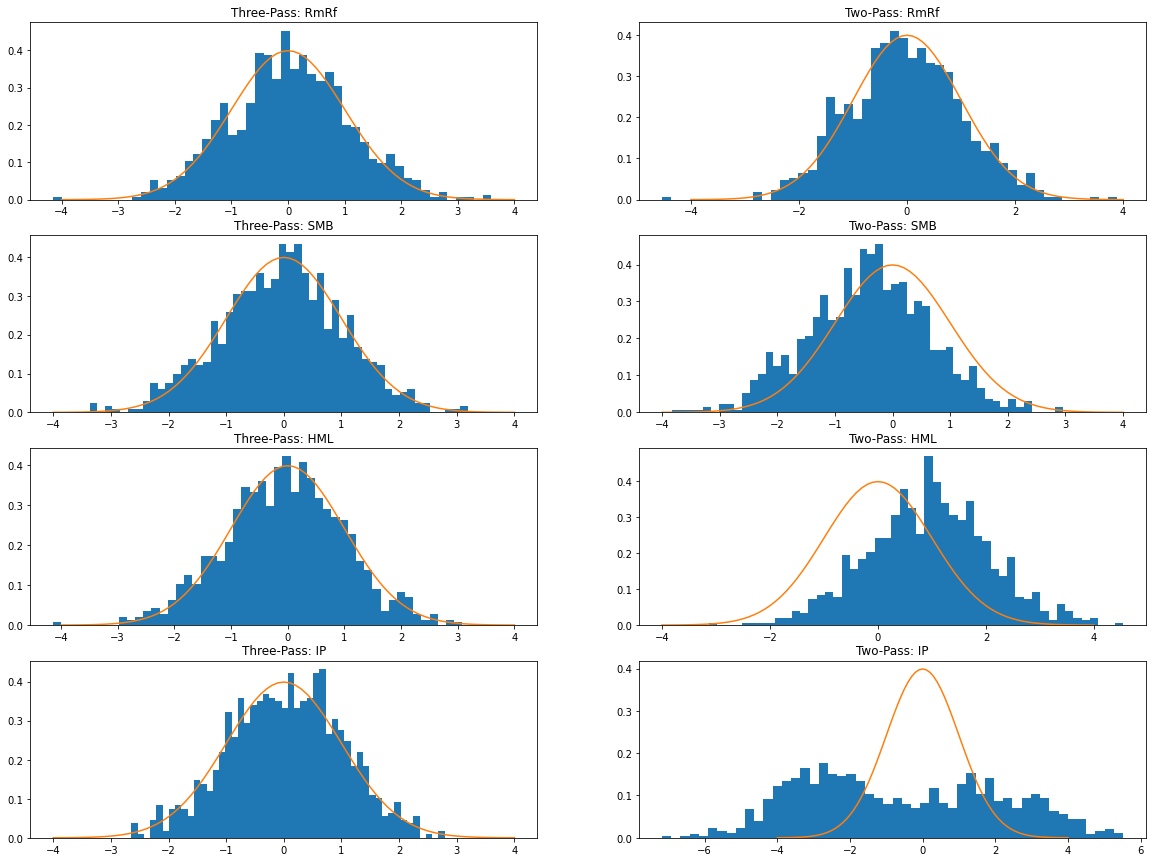

In [179]:
# Top left and top right
plt.figure(figsize = (20,15))
nbins  = 50
title_list = ['Three-Pass: RmRf','Two-Pass: RmRf','Three-Pass: SMB','Two-Pass: SMB',
              'Three-Pass: HML','Two-Pass: HML','Three-Pass: IP','Two-Pass: IP']
for i in range(4):
    plt.subplot(4,2,2*i+2)
    plt.hist((output['GammaFM'][i,:]- output['Gammatrue'][i])/np.sqrt(output['avarhatFM'][i,:]), 
              bins = nbins, density = True)
    xp = np.linspace(-4,4,81)
    yp = stats.norm.pdf(xp)
    plt.plot(xp, yp)
    plt.title(title_list[2*i+1])

for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.hist((output['Gammahat'][i,4,:]- output['Gammatrue'][i])/np.sqrt(output['avarhat'][i,4,:]), 
              bins = nbins, density = True)
    xp = np.linspace(-4,4,81)
    yp = stats.norm.pdf(xp)
    plt.plot(xp, yp)
    plt.title(title_list[2*i])
    

Using the following codes to draw figures and comment on the performance of this approach.

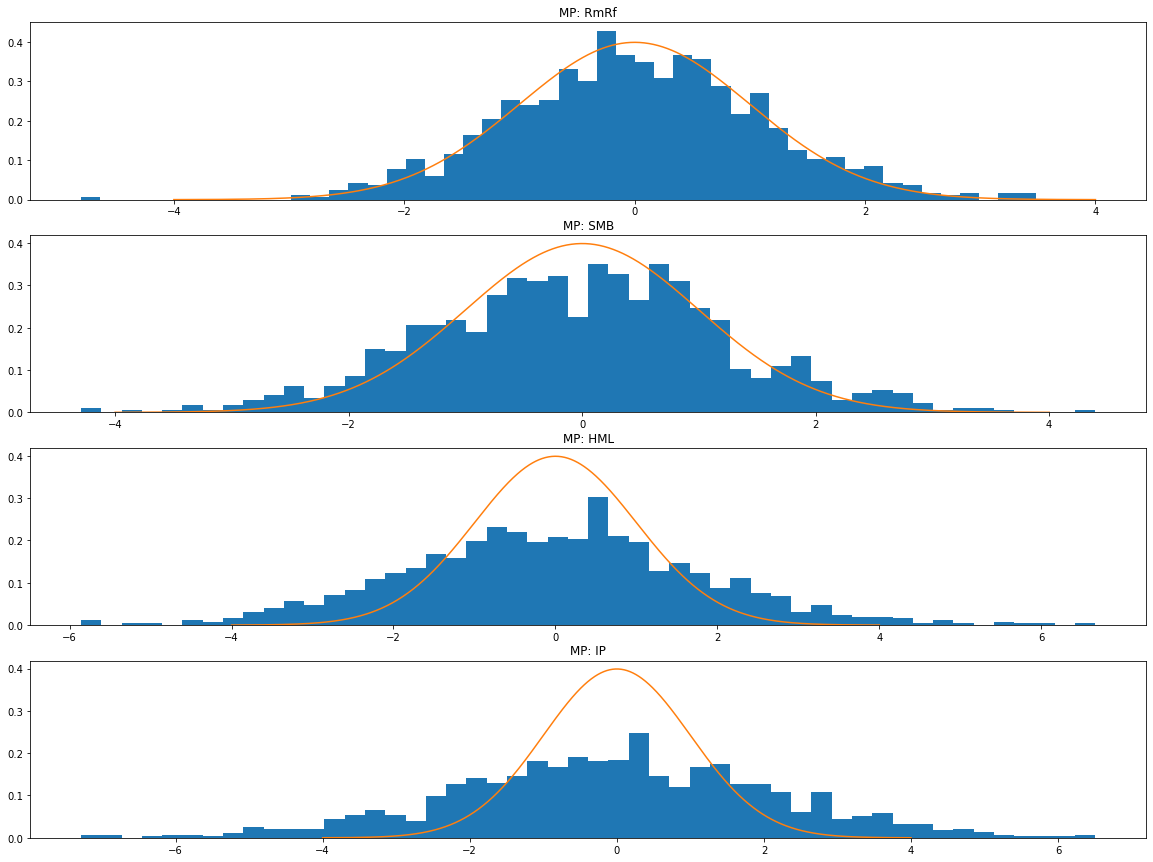

In [180]:
# bottom right
plt.figure(figsize = (20,15))
nbins  = 50
title_list = ['MP: RmRf','MP: SMB','MP: HML','MP: IP']
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.hist((output['gtMP'][i,:]- output['Gammatrue'][i])/np.sqrt(output['gtavarMP'][i,:]),
                  bins = nbins, density = True)
    xp = np.linspace(-4,4,1000)
    yp = stats.norm.pdf(xp)
    plt.plot(xp, yp)
    plt.title(title_list[i])



Use the following plots to observe the effect of missing factors. The true number of factors is 5. Comment on your findings.

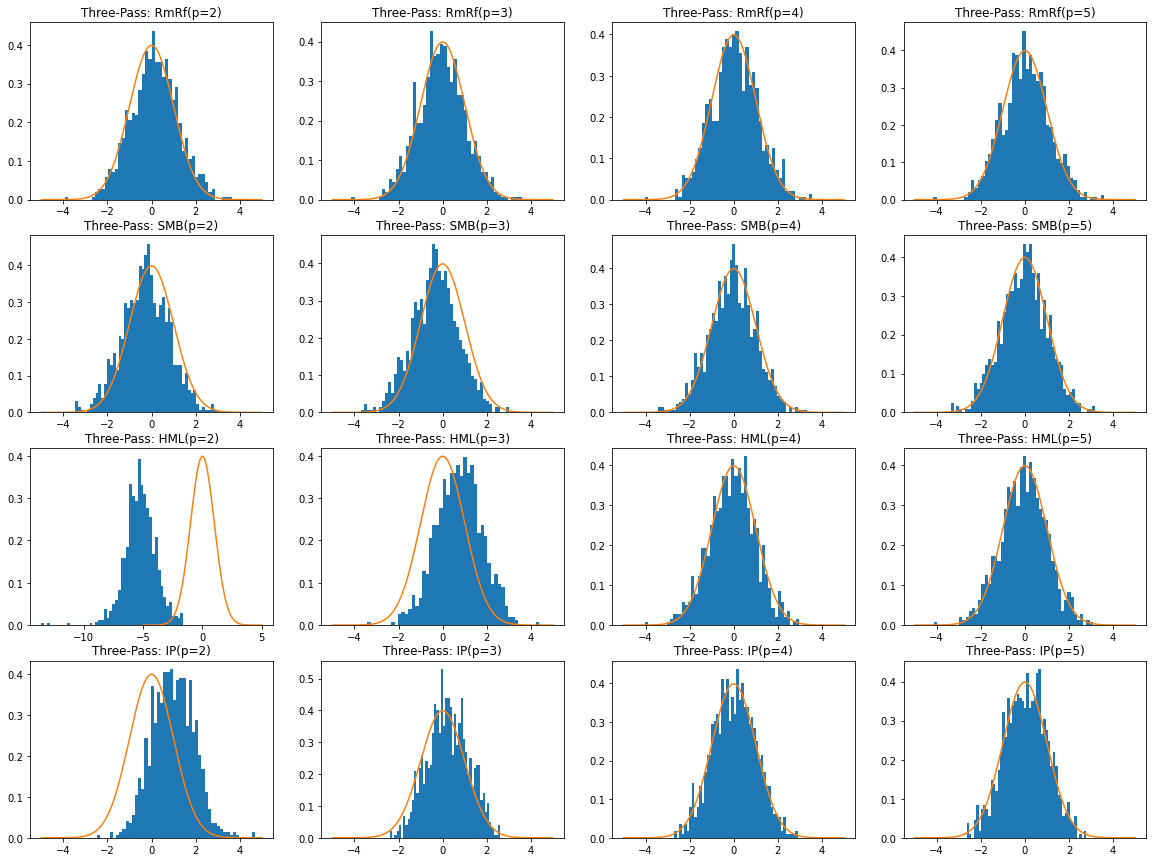

In [181]:
# Three-pass: different p

# Top left and top right
plt.figure(figsize = (20,15))
nbins  = 50
title_list = ['Three-Pass: RmRf(p=2)','Three-Pass: SMB(p=2)',
              'Three-Pass: HML(p=2)','Three-Pass: IP(p=2)',
              'Three-Pass: RmRf(p=3)','Three-Pass: SMB(p=3)',
              'Three-Pass: HML(p=3)','Three-Pass: IP(p=3)',
             'Three-Pass: RmRf(p=4)','Three-Pass: SMB(p=4)',
              'Three-Pass: HML(p=4)','Three-Pass: IP(p=4)',
             'Three-Pass: RmRf(p=5)','Three-Pass: SMB(p=5)',
              'Three-Pass: HML(p=5)','Three-Pass: IP(p=5)',]
for p in range(4):
    for i in range(4):
        plt.subplot(4,4,4*i+p+1)
        plt.hist((output['Gammahat'][i,p+1,:]- output['Gammatrue'][i])/np.sqrt(output['avarhat'][i,p+1,:]), 
              bins = nbins, density = True)
        xp = np.linspace(-5,5,1000)
        yp = stats.norm.pdf(xp)
        plt.plot(xp, yp)
        plt.title(title_list[4*p+i])
    
